# Geometric representation

We saw how we can calculate the integral of the function represented by the
neural network in a SQL query. Taking a step back, we can instead construct the
geometric representation of the network's function (i.e. the breakpoints and
their slopes). Once we have this, we can calculate the integral on top of it.

## The network

We'll use the same function and network from [the integral query's discussion](./3.1%20Integral.ipynb).

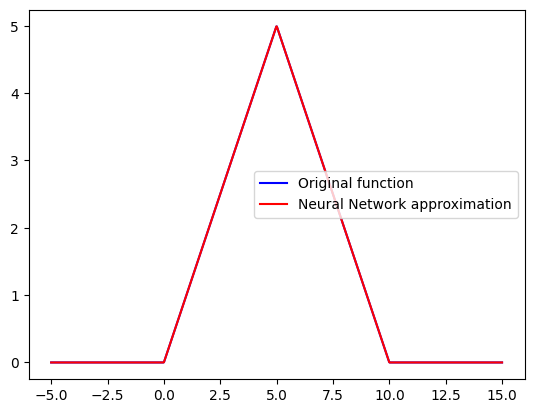

In [1]:
import torch
import torch.onnx
import numpy as np
import matplotlib.pyplot as plt
import utils.duckdb as db
import utils.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import math

torch.manual_seed(110033)

def f(x):
    if x < 0:
        return 0
    elif 0 <= x < 5:
        return x
    elif 5 <= x < 10:
        return 10-x
    else:
        return 0

x_train = np.linspace(-5, 15, 1000)
y_train = np.array([f(x) for x in x_train])

model = nn.ReLUFNN(input_size=1, output_size=1, hidden_size=3, num_hidden_layers=1)
nn.train(model, x_train, y_train, save_path="models/integral_geometric.pt")

model.eval()
with torch.no_grad():
    predicted = model(torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)).detach().numpy()

plt.plot(x_train, y_train, 'b', label='Original function')
plt.plot(x_train, predicted, 'r', label='Neural Network approximation')
plt.legend()
plt.show()

db.load_pytorch_model_into_db(model)

## The query

The following query is a straightforward adaptation from [the integral
query](./3.1%20Integral.ipynb) where we instead simply retain the x and y
coordinates of the breakpoints, and the slope to the next breakpoint.

In [2]:
query = """
WITH
-- Node selectors
input_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT dst FROM edge)
),
output_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT src FROM edge)
),
hidden_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (
        SELECT * FROM input_nodes
        UNION
        SELECT * FROM output_nodes
    )
),
breakpoints AS (
    SELECT
        n.id,
        (-n.bias) / e.weight AS break_x, -- -b(u) / w(in1, u)
        ROW_NUMBER() OVER (ORDER BY (-n.bias) / e.weight) AS row_number
    FROM node n
    JOIN edge e ON e.dst = n.id
    JOIN input_nodes i ON e.src = i.id
    JOIN hidden_nodes h ON h.id = n.id
    WHERE e.weight <> 0
    -- GROUP BY to avoid duplicate breakpoints.
    GROUP BY break_x, n.id
    ORDER BY break_x
),

-- Eval query
input_values AS (
    SELECT break_x AS input_value FROM breakpoints
),
t1 AS (
    SELECT
        v.input_value,
        GREATEST(
            0,
            n.bias + SUM(e.weight * v.input_value)
        ) AS t1,
        e.dst AS id
    FROM edge e
    JOIN input_nodes i ON i.id = e.src
    JOIN node n ON e.dst = n.id
    CROSS JOIN input_values v
    GROUP BY v.input_value, e.dst, n.bias
),
output_values AS (
    SELECT
        t1.input_value,
        n.bias + SUM(e.weight * t1.t1) AS output_value,
        e.dst AS output_node_id
    FROM edge e
    JOIN t1 ON t1.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY t1.input_value, e.dst, n.bias
),

-- Calculating breakpoints and their slopes.
breakpoint_pairs AS (
    SELECT
        u1.break_x AS u1_break_x,
        u2.break_x AS u2_break_x,
        e1.output_value AS u1_break_y,
        e2.output_value AS u2_break_y
    FROM breakpoints u1
    JOIN breakpoints u2 ON u1.row_number = u2.row_number - 1
    JOIN output_values e1 ON u1.break_x = e1.input_value
    JOIN output_values e2 ON u2.break_x = e2.input_value
),
points_and_slopes AS (
    SELECT
        u1_break_x AS x,
        u1_break_y AS y,
        -- (y2 - y1) / (x2 - x1)
        (u2_break_y - u1_break_y) / (u2_break_x - u1_break_x) AS slope
    FROM breakpoint_pairs
)
SELECT * FROM points_and_slopes
ORDER BY x;
"""

db.con.sql(query)

┌────────────────┬─────────────────────────┬─────────────────────┐
│       x        │            y            │        slope        │
│     float      │         double          │       double        │
├────────────────┼─────────────────────────┼─────────────────────┤
│ -1.0918143e-05 │ -1.0492646325133137e-05 │  1.0000308991376736 │
│      4.9998784 │       5.000033373403085 │ -0.9999513442997937 │
└────────────────┴─────────────────────────┴─────────────────────┘

## The query, with extra start/end breakpoint

To fully capture the network, we need an artificial extra start and end
breakpoint. DuckDB supports positive and negative infinity, but the calculations
result into NaNs. Instead, we'll take a point at an arbitrary distance before
the first and after the last breakpoint. In our case, we take 10 as the
distance.

In [3]:
query = """
WITH
input_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT dst FROM edge)
),
output_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT src FROM edge)
),
hidden_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (
        SELECT * FROM input_nodes
        UNION
        SELECT * FROM output_nodes
    )
),
breakpoint_values AS (
    SELECT
        (-n.bias) / e.weight AS break_x,
    FROM node n
    JOIN edge e ON e.dst = n.id
    JOIN input_nodes i ON e.src = i.id
    JOIN hidden_nodes h ON h.id = n.id
    WHERE e.weight <> 0
    GROUP BY break_x, n.id
    ORDER BY break_x
),
breakpoints_unordered AS (
    (SELECT break_x FROM breakpoint_values)
    UNION
    (SELECT MIN(break_x) - 10.0 AS break_x FROM breakpoint_values)
    UNION
    (SELECT MAX(break_x) + 10.0 AS break_x FROM breakpoint_values)
),
breakpoints AS (
    SELECT
        break_x,
        ROW_NUMBER() OVER (ORDER BY break_x) AS row_number
    FROM breakpoints_unordered
),

input_values AS (
    SELECT break_x AS input_value FROM breakpoints
),
t1 AS (
    SELECT
        v.input_value,
        GREATEST(
            0,
            n.bias + SUM(e.weight * v.input_value)
        ) AS t1,
        e.dst AS id
    FROM edge e
    JOIN input_nodes i ON i.id = e.src
    JOIN node n ON e.dst = n.id
    CROSS JOIN input_values v
    GROUP BY v.input_value, e.dst, n.bias
),
output_values AS (
    SELECT
        t1.input_value,
        n.bias + SUM(e.weight * t1.t1) AS output_value,
        e.dst AS output_node_id
    FROM edge e
    JOIN t1 ON t1.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY t1.input_value, e.dst, n.bias
),

breakpoint_pairs AS (
    SELECT
        u1.break_x AS u1_break_x,
        u2.break_x AS u2_break_x,
        e1.output_value AS u1_break_y,
        e2.output_value AS u2_break_y
    FROM breakpoints u1
    JOIN breakpoints u2 ON u1.row_number = u2.row_number - 1
    JOIN output_values e1 ON u1.break_x = e1.input_value
    JOIN output_values e2 ON u2.break_x = e2.input_value
),
points_and_slopes AS (
    SELECT
        u1_break_x AS x,
        u1_break_y AS y,
        (u2_break_y - u1_break_y) / (u2_break_x - u1_break_x) AS slope
    FROM breakpoint_pairs
)
SELECT * FROM points_and_slopes
ORDER BY x;
"""
db.con.sql(query)

┌────────────────┬─────────────────────────┬────────────────────────┐
│       x        │            y            │         slope          │
│     float      │         double          │         double         │
├────────────────┼─────────────────────────┼────────────────────────┤
│    -10.0000105 │  -0.0003988036515920612 │ 3.8831100526692806e-05 │
│ -1.0918143e-05 │ -1.0492646325133137e-05 │     1.0000308991376736 │
│      4.9998784 │       5.000033373403085 │    -0.9999513442997937 │
│      10.000131 │   2.441732067381963e-05 │                    0.0 │
└────────────────┴─────────────────────────┴────────────────────────┘

With this, we fully capture the network. As an example application, let's create
a plot of the model using only this geometric information.

In [4]:
db.con.execute(query).df()

,x,y,slope
0,-10.000010,-0.000399,0.000039
1,-0.000011,-0.000010,1.000031
2,4.999878,5.000033,-0.999951
3,10.000131,0.000024,0.000000


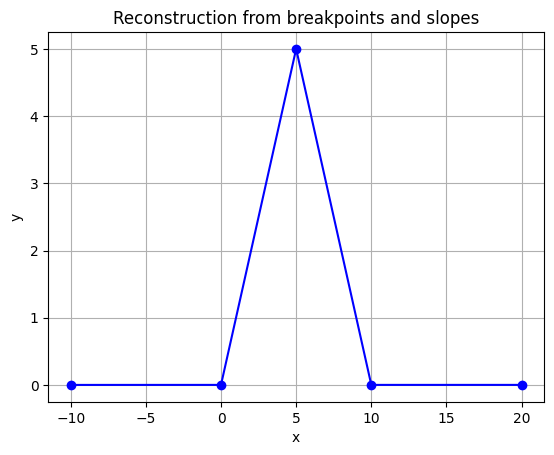

In [5]:
result_df = db.con.execute(query).df()

x_values = result_df['x'].values
y_values = result_df['y'].values
slopes = result_df['slope'].values

x_plot = [x_values[0]]
y_plot = [y_values[0]]

for i in range(len(slopes) - 1):
    next_x = x_values[i + 1]
    delta_x = next_x - x_plot[-1]
    delta_y = slopes[i] * delta_x
    y_next = y_plot[-1] + delta_y

    x_plot.append(next_x)
    y_plot.append(y_next)

# Also show the next 10 units of the last slope
last_slope = slopes[-1]
last_x = x_plot[-1]
last_y = y_plot[-1]
extend_x = last_x + 10
extend_y = last_y + last_slope * (extend_x - last_x)
x_plot.append(extend_x)
y_plot.append(extend_y)

plt.plot(x_plot, y_plot, marker='o', linestyle='-', color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reconstruction from breakpoints and slopes')
plt.grid(True)
plt.show()

## Using the geometric representation to calculate the integral

With the geometric representation at hand, it becomes trivial to calculate the
integral of the function.

In [6]:
integral_query = """
WITH
input_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT dst FROM edge)
),
output_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (SELECT src FROM edge)
),
hidden_nodes AS (
    SELECT id
    FROM node
    WHERE id NOT IN
    (
        SELECT * FROM input_nodes
        UNION
        SELECT * FROM output_nodes
    )
),
breakpoint_values AS (
    SELECT
        (-n.bias) / e.weight AS break_x,
    FROM node n
    JOIN edge e ON e.dst = n.id
    JOIN input_nodes i ON e.src = i.id
    JOIN hidden_nodes h ON h.id = n.id
    WHERE e.weight <> 0
    GROUP BY break_x, n.id
    ORDER BY break_x
),
breakpoints_unordered AS (
    (SELECT break_x FROM breakpoint_values)
    UNION
    (SELECT MIN(break_x) - 10.0 AS break_x FROM breakpoint_values)
    UNION
    (SELECT MAX(break_x) + 10.0 AS break_x FROM breakpoint_values)
),
breakpoints AS (
    SELECT
        break_x,
        ROW_NUMBER() OVER (ORDER BY break_x) AS row_number
    FROM breakpoints_unordered
),

input_values AS (
    SELECT break_x AS input_value FROM breakpoints
),
t1 AS (
    SELECT
        v.input_value,
        GREATEST(
            0,
            n.bias + SUM(e.weight * v.input_value)
        ) AS t1,
        e.dst AS id
    FROM edge e
    JOIN input_nodes i ON i.id = e.src
    JOIN node n ON e.dst = n.id
    CROSS JOIN input_values v
    GROUP BY v.input_value, e.dst, n.bias
),
output_values AS (
    SELECT
        t1.input_value,
        n.bias + SUM(e.weight * t1.t1) AS output_value,
        e.dst AS output_node_id
    FROM edge e
    JOIN t1 ON t1.id = e.src
    JOIN node n ON e.dst = n.id
    GROUP BY t1.input_value, e.dst, n.bias
),
breakpoint_pairs AS (
    SELECT
        u1.break_x AS u1_break_x,
        u2.break_x AS u2_break_x,
        e1.output_value AS u1_break_y,
        e2.output_value AS u2_break_y
    FROM breakpoints u1
    JOIN breakpoints u2 ON u1.row_number = u2.row_number - 1
    JOIN output_values e1 ON u1.break_x = e1.input_value
    JOIN output_values e2 ON u2.break_x = e2.input_value
),
points_and_slopes AS (
    SELECT
        u1_break_x AS x,
        u1_break_y AS y,
        (u2_break_y - u1_break_y) / (u2_break_x - u1_break_x) AS slope
    FROM breakpoint_pairs
),

-- Given points_and_slopes, we can calculate the integral from them.
points_and_slopes_with_next AS (
    SELECT
        x,
        y,
        slope,
        LEAD(x) OVER (ORDER BY x) AS next_x
    FROM points_and_slopes
)

SELECT
    SUM(((y + (y + slope * (next_x - x))) / 2) * (next_x - x)) AS integral
FROM
    points_and_slopes_with_next
WHERE next_x IS NOT NULL
"""
db.con.sql(integral_query)

┌───────────────────┐
│     integral      │
│      double       │
├───────────────────┤
│ 24.99850925482483 │
└───────────────────┘

The trick here is in the last 2 parts:

```sql
points_and_slopes_with_next AS (
    SELECT
        x,
        y,
        slope,
        LEAD(x) OVER (ORDER BY x) AS next_x
    FROM points_and_slopes
)
```

Here we select the breakpoints as pairs again, using SQL's `LEAD` function to
get the next value according to some ordering.

With this in hand, we calculate the actual integral:

```SQL
SELECT
    SUM(((y + (y + slope * (next_x - x))) / 2) * (next_x - x)) AS integral
FROM
    points_and_slopes_with_next
WHERE next_x IS NOT NULL
```

This relies on the formula:

$$
A = \frac{y_1 + y_{i+1}}{2} \cdot (x_{i+1} - x_i)
$$

We could technically fetch $y_{i+1}$ from the `points_and_slopes` CTE as well,
but we can also use the slope to calculate it, which we do:

$$
y_{i+1} = y_i + slope \cdot (x_{i+1} - x_i)
$$

## Getting the geometry of a more interesting function

Our function is pretty trivial. Let's instead see if we can train a network to
learn $y = sin(x)$ and get the geometry of that.

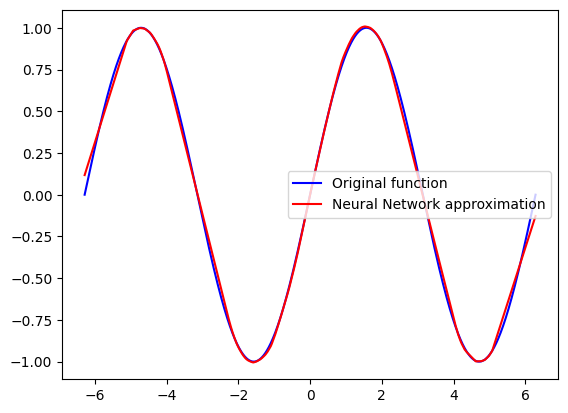

In [7]:
torch.manual_seed(1)

x_train = np.linspace(-2*math.pi, 2*math.pi, 10000)
y_train = np.array([math.sin(x) for x in x_train])

model = nn.ReLUFNN(input_size=1, output_size=1, hidden_size=1000, num_hidden_layers=1)
nn.train(model, x_train, y_train, epochs=750, save_path="models/integral_geometric_sine.pt")

model.eval()
with torch.no_grad():
    predicted = model(torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)).detach().numpy()

plt.plot(x_train, y_train, 'b', label='Original function')
plt.plot(x_train, predicted, 'r', label='Neural Network approximation')
plt.legend()
plt.show()

db.load_pytorch_model_into_db(model)

We can see that the trained function is not perfect, but still a pretty good
match. Let's get the geometric representation of it.

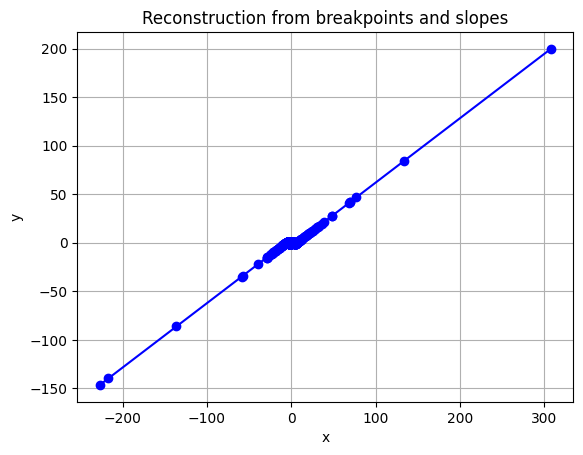

In [8]:
result_df = db.con.execute(query).df()

x_values = result_df['x'].values
y_values = result_df['y'].values
slopes = result_df['slope'].values

x_plot = [x_values[0]]
y_plot = [y_values[0]]

for i in range(len(slopes) - 1):
    next_x = x_values[i + 1]
    delta_x = next_x - x_plot[-1]
    delta_y = slopes[i] * delta_x
    y_next = y_plot[-1] + delta_y

    x_plot.append(next_x)
    y_plot.append(y_next)

plt.plot(x_plot, y_plot, marker='o', linestyle='-', color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reconstruction from breakpoints and slopes')
plt.grid(True)
plt.show()

This graph is a bit messy, because some breakpoints are located out of the area
we trained our sine on. Let's zoom in a bit.

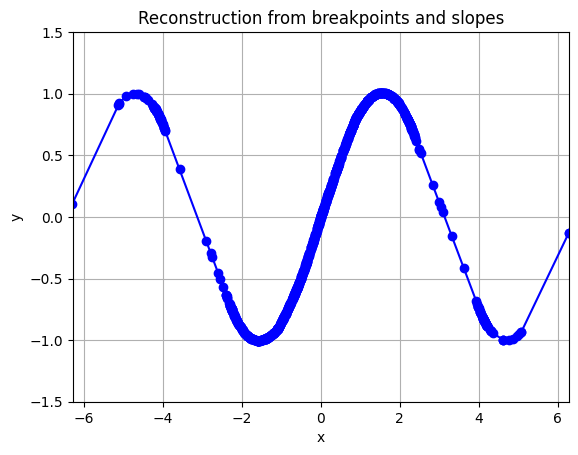

In [12]:
plt.plot(x_plot, y_plot, marker='o', linestyle='-', color='b', label='Reconstruction')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Reconstruction from breakpoints and slopes')
plt.grid(True)
plt.xlim(-2*math.pi, 2*math.pi)
plt.ylim(-1.5, 1.5)
plt.show()

This plot shows how we nicely reconstruct the output of the neural network.